In [3]:
import numpy as np 
import pandas as pd

from gsdmm import MovieGroupProcess
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.util import ngrams

from nltk.tokenize import MWETokenizer
from nltk.corpus import stopwords as nltkStopwords
from nltk.stem import WordNetLemmatizer

In [4]:
import csv

In [5]:
def getData(challengesFile,outcomesFile):
    data_dict = {}
    with open(challengesFile,encoding='utf-8') as file:
        data = csv.reader(file)
        sess_id = None
        for row in data:
            row = ' '.join(row)
            if row.startswith("Session"):
                sess_id = int(row.split(' ')[1])
                if sess_id not in data_dict.keys():
                    data_dict[sess_id] = {"challenges": [], "outcomes": []}
                continue
            data_dict[sess_id]["challenges"].append(row)
    with open(outcomesFile,encoding='utf-8') as file:
        data = csv.reader(file)
        sess_id = None
        for row in data:
            row = ' '.join(row)
            if row.startswith("Session"):
                sess_id = int(row.split(' ')[1])
                continue
            data_dict[sess_id]["outcomes"].append(row)
    return data_dict

In [6]:
def multiWordTokenize(tokens):
    mweTokenizer = MWETokenizer()
    multiWords = ['web services', 'soap-based architure', 'rest api', 'web services', 'web service',
                  'external reading', 'soap envelope', 'service oriented architecture', 'service oriented',
                  'rest services', 'web services', 'soap web services', 'simple web page', 
                  'application programming interface', 'set collection', '.net developer', 
                  'stack frames', 'cascade pattern', 'node package', 'version control', 
                  'node js', 'micro api', 'wsdl descriptor', 'asynchronous operation', 'computer application']
    for mw in multiWords:
#         print(mw.split(' '))
        mweTokenizer.add_mwe(mw.split(' '))
    mweTokenizer.add_mwe(('web', 'services'))
    tokens = mweTokenizer.tokenize(tokens)
    return tokens

In [7]:
ourDict = ['soap', 'soap-based' ,'soap-based_architecture','service_oriented_architecture',  'wsdl', 'web_services','web_service', 
               'closure','soap','javascript','plugin','object','wsdl','architecture','service', 'oreinted', 'service_oriented',
               'interface','rest','uddl','dependency','pom','xml','eclipse','achitecture',
               'collection','variable','syntax','export','cascade','pattern','package','manager',
               'namespace','chrome','extension','client', 'service-oriented', 'computer', 'application', 
               'web_services', 'soap-based_architure', 'rest_api', 'web_services', 'external_reading', 
               'soap_envelope', 'service_oriented_architecture', 'rest_services', 'web_services', 
               'soap_web_services', 'simple_web_page', 'application_programming_interface', 
               'set_collection', '.net_developer', 'stack_frames', 'cascade_pattern', 
               'node_package', 'version_control', 'node_js', 'micro_api', 
               'wsdl_descriptor', 'asynchronous_operation', 'soap', 'wsdl', 'soa', 'computer', 'applications', 
               'rest', 'xml', 'url', 'http', 'wcf', 'websockets', 'graphql', 'website', 'api','apis', 'javascript', 
               'cxf', 'javascript', 'rest', 'json', 'language-independent', 'dom', 'ecmascript', 'closures', 
               'map', 'netscape', 'set', 'c#', 'iife', 'coupling', 'js', 'git', 'git', 'ide', 'npm', 'nodejs', 'microservices', 'micro_services']
def sent_to_words(sentences):
    tokens = []
    for sentence in sentences:
        sentence = sentence.lower()
        temp = multiWordTokenize(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        temp = [x for x in temp if x in ourDict]
        tokens.append(temp)
#     print(tokens)
    return tokens

In [8]:
def remove_stopwords(texts):
    stopwords = []
    return [[word for word in simple_preprocess(str(doc)) 
                 if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(stopwords))] 
                for doc in texts]

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', "ADP"]):
    ignore_words = ['js']
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        temp = []
        for token in doc:
            if str(token).lower() in ignore_words:
                temp.append(str(token).lower())
                continue
            if token.pos_ in allowed_postags:
                temp.append(token.lemma_)
        texts_out.append(temp)
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
reviews = getData("challenges.csv", "learning_outcomes.csv")
dataset = getData("challenges.csv", "learning_outcomes.csv")
## Preprocessing 

for sess in reviews:
    
    reviews[sess]["challenges"] = [re.sub('\s+', ' ', sent) for sent in reviews[sess]["challenges"]]
    reviews[sess]["challenges"] = list(sent_to_words(reviews[sess]["challenges"]))
    reviews[sess]["challenges"] = remove_stopwords(reviews[sess]["challenges"])
    reviews[sess]["challenges"] = lemmatization(reviews[sess]["challenges"])
    
    
    reviews[sess]["outcomes"] = [re.sub('\s+', ' ', sent) for sent in reviews[sess]["outcomes"]]
    reviews[sess]["outcomes"] = list(sent_to_words(reviews[sess]["outcomes"]))
    reviews[sess]["outcomes"] = remove_stopwords(reviews[sess]["outcomes"])
    reviews[sess]["outcomes"] = lemmatization(reviews[sess]["outcomes"])



In [11]:
from pprint import pprint
pprint(reviews)

{1: {'challenges': [['wsdl'],
                    ['soa'],
                    [],
                    [],
                    ['wsdl', 'soap', 'web_service'],
                    ['web_service', 'interface'],
                    ['soap', 'rest'],
                    ['plugin'],
                    [],
                    [],
                    [],
                    [],
                    ['soap', 'web_service'],
                    ['application'],
                    [],
                    [],
                    [],
                    [],
                    [],
                    ['achitecture']],
     'outcomes': [['soap', 'architecture', 'wsdl'],
                  ['soa', 'application'],
                  ['soap', 'rest', 'soap'],
                  ['soap', 'rest', 'application', 'xml', 'rest'],
                  ['soa'],
                  ['rest',
                   'soap',
                   'rest',
                   'soap',
                   'xml',
                   

In [12]:
def top_words(cluster_word_distribution, top_cluster, values):
    topics = []
    for cluster in top_cluster:
        sort_dicts =sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
#         print("\nCluster %s : %s"%(cluster,sort_dicts))
        topics.append(sort_dicts)
    return topics

In [13]:
def get_topics(data):
    mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)
    vocab = set(x for review in data for x in review)
    model = mgp.fit(data, len(vocab))
    doc_count = np.array(mgp.cluster_doc_count)
    top_index = doc_count.argsort()[-10:][::-1]
    topics = top_words(mgp.cluster_word_distribution, top_index, 10)
    labels = []
    for x in data:
        labels.append(topics[mgp.choose_best_label(x)[0]])
    return topics, labels
    

In [14]:
total_challenges, total_outcomes = [], []
for sess in reviews:
    total_challenges.extend(reviews[sess]['challenges'])
    total_outcomes.extend(reviews[sess]['outcomes'])
challenges_clusters, all_challenges_topics = get_topics(total_challenges)
outcomes_clusters, all_outcomes_topics = get_topics(total_outcomes)


review_topics = {}
index = 0
for sess in reviews:
    review_topics[sess] = {"challenges": [], "outcomes" : []}
    for _ in range(len(reviews[sess]["challenges"])):
        review_topics[sess]["challenges"].append(all_challenges_topics[index])
        review_topics[sess]["outcomes"].append(all_outcomes_topics[index])
        index += 1

In stage 0: transferred 70 clusters with 6 clusters populated
In stage 1: transferred 56 clusters with 6 clusters populated
In stage 2: transferred 54 clusters with 6 clusters populated
In stage 3: transferred 43 clusters with 6 clusters populated
In stage 4: transferred 52 clusters with 6 clusters populated
In stage 5: transferred 49 clusters with 6 clusters populated
In stage 6: transferred 45 clusters with 5 clusters populated
In stage 7: transferred 43 clusters with 5 clusters populated
In stage 8: transferred 51 clusters with 5 clusters populated
In stage 9: transferred 44 clusters with 5 clusters populated
In stage 10: transferred 41 clusters with 5 clusters populated
In stage 11: transferred 49 clusters with 5 clusters populated
In stage 12: transferred 39 clusters with 5 clusters populated
In stage 13: transferred 43 clusters with 5 clusters populated
In stage 14: transferred 45 clusters with 5 clusters populated
In stage 15: transferred 44 clusters with 5 clusters populated
In

In [15]:
def filterData(actual, topics, sentence):
    filtered = actual
    words = sentence.lower().split(' ')
    for x in topics:
        if x[0] in lemmatization([actual]):
            filtered.append(x)
#     for x in words:
#         if x in ourDict:
#             filtered.append(x)
    return list(set(filtered))

In [16]:
for sess in reviews:
    for index, chal in enumerate(reviews[sess]["challenges"]):
        
        review_topics[sess]["challenges"][index] = filterData(chal, review_topics[sess]["challenges"][index], dataset[sess]["challenges"][index])
    
    for index, out in enumerate(reviews[sess]["outcomes"]):    
        review_topics[sess]["outcomes"][index] = filterData(out, review_topics[sess]["outcomes"][index], dataset[sess]["outcomes"][index])
   
pprint(review_topics)

{1: {'challenges': [['wsdl'],
                    ['soa'],
                    [],
                    [],
                    ['soap', 'web_service', 'wsdl'],
                    ['interface', 'web_service'],
                    ['soap', 'rest'],
                    ['plugin'],
                    [],
                    [],
                    [],
                    [],
                    ['soap', 'web_service'],
                    ['application'],
                    [],
                    [],
                    [],
                    [],
                    [],
                    ['achitecture']],
     'outcomes': [['architecture', 'soap', 'wsdl'],
                  ['soa', 'application'],
                  ['soap', 'rest'],
                  ['xml', 'soap', 'rest', 'application'],
                  ['soa'],
                  ['http', 'xml', 'rest', 'soap', 'soap_envelope'],
                  ['soa', 'web_service'],
                  ['api', 'soap', 'web_service', 'object', 

In [17]:
topic_wise = {}

for sess in review_topics:
    temp = {}
    for index, chals in enumerate(review_topics[sess]["challenges"]):
        for chal in chals:
            if not temp.get(chal, None):
                temp[chal] = {"challenges":[], "outcomes":[], "frequency":{"challenges":0, "outcomes":0}}
            temp[chal]["challenges"].append(dataset[sess]["challenges"][index])
    
    for index, outs in enumerate(review_topics[sess]["outcomes"]):
        for out in outs:
            if not temp.get(out, None):
                temp[out] = {"challenges":[], "outcomes":[], "frequency":{"challenges":0, "outcomes":0}}
            temp[out]["outcomes"].append(dataset[sess]["outcomes"][index])
    topic_wise[sess] = temp
    
# pprint(topic_wise)
for sess in dataset:
    topic_wise[sess]["__participants"] = len(dataset[sess]["challenges"])
    for topic in topic_wise[sess].keys():
        
        for chal in dataset[sess]["challenges"]:
            chal = chal.lower()
            if topic in chal:
                topic_wise[sess][topic]["frequency"]["challenges"] += 1
        for out in dataset[sess]["outcomes"]:
            out = out.lower()
            if topic in out:
                topic_wise[sess][topic]["frequency"]["outcomes"] += 1
# pprint(topic_wise)


In [18]:
import json
with open('./web-ui/src/data.json', 'w', encoding='utf-8') as f:
    json.dump(topic_wise, f, ensure_ascii=False, indent=4)

In [19]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show()

In [20]:
topic_wise = {}

for sess in review_topics:
    temp = {}
    for index, chals in enumerate(review_topics[sess]["challenges"]):
        for chal in chals:
            if not temp.get(chal, None):
                temp[chal] = {"challenges":[], "outcomes":[], "frequency":{"challenges":0, "outcomes":0}}
            temp[chal]["challenges"].append(dataset[sess]["challenges"][index])
    
    for index, outs in enumerate(review_topics[sess]["outcomes"]):
        for out in outs:
            if not temp.get(out, None):
                temp[out] = {"challenges":[], "outcomes":[], "frequency":{"challenges":0, "outcomes":0}}
            temp[out]["outcomes"].append(dataset[sess]["outcomes"][index])
    topic_wise[sess] = temp
    
# pprint(topic_wise)
for sess in dataset:
    for topic in topic_wise[sess].keys():
        topic_wise[sess][topic]["frequency"]["challenges"] = len(topic_wise[sess][topic]["challenges"])
        topic_wise[sess][topic]["frequency"]["outcomes"] = len(topic_wise[sess][topic]["outcomes"])
    topic_wise[sess]["__participants"] = len(dataset[sess]["challenges"])
    
#         for chal in dataset[sess]["challenges"]:
#             chal = chal.lower()
#             if topic in chal:
#                 topic_wise[sess][topic]["frequency"]["challenges"] += 1
        
#         for out in dataset[sess]["outcomes"]:
#             out = out.lower()
#             if topic in out:
#                 topic_wise[sess][topic]["frequency"]["outcomes"] += 1
# pprint(topic_wise)
for sess in topic_wise:
    challenges_topics = list(topic_wise[sess].keys())
    challenges_topics.remove("__participants")
    challenges_topics.sort(key = lambda x : len(topic_wise[sess][x]["challenges"]), reverse= True)
    
    
    outcomes_topics = list(topic_wise[sess].keys())
    outcomes_topics.remove("__participants")
    outcomes_topics.sort(key = lambda x : len(topic_wise[sess][x]["outcomes"]), reverse= True)
    
    topic_wise[sess]["challenge_topics"] = challenges_topics
    topic_wise[sess]["outcome_topics"] = outcomes_topics
    
    topic_wise[sess]["challenge_topics_freq"] = []
    topic_wise[sess]["outcome_topics_freq"] = []
    for x in challenges_topics:
            topic_wise[sess]["challenge_topics_freq"].append(len(topic_wise[sess][x]["challenges"]))
    for x in outcomes_topics:
        topic_wise[sess]["outcome_topics_freq"].append(len(topic_wise[sess][x]["outcomes"]))
pprint(topic_wise)

{1: {'__participants': 20,
     'achitecture': {'challenges': ['Service Oriented Achitecture'],
                     'frequency': {'challenges': 1, 'outcomes': 0},
                     'outcomes': []},
     'api': {'challenges': [],
             'frequency': {'challenges': 0, 'outcomes': 1},
             'outcomes': ['The presentation easily explained what web services '
                          'are and the use cases. I like the detailed '
                          'explanation of Simple Object Access Protocol '
                          '(SOAP). When I tried to understand SOAP '
                          'architecture in the past, it was not successful. '
                          "However, your presentation's SOAP use scenario, "
                          'components, and example helped me to fully '
                          'understand what is SOAP architecture. Another '
                          'interesting concept was that web services are a '
                          'type 

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def create_WordCloud(data, title=None):
    if len(data) == 0:
        return
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show()

SESSION :  1
Challenges


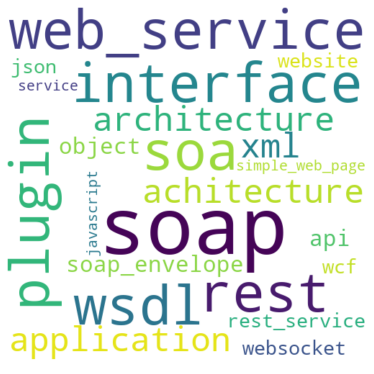

Outcome


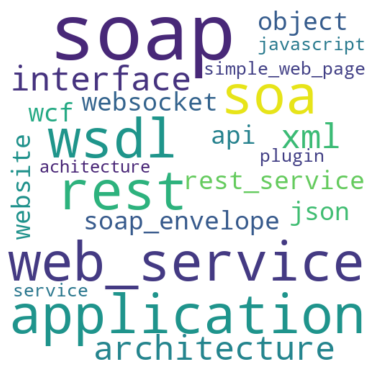

SESSION :  2
Challenges


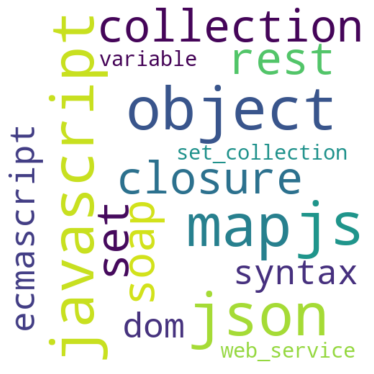

Outcome


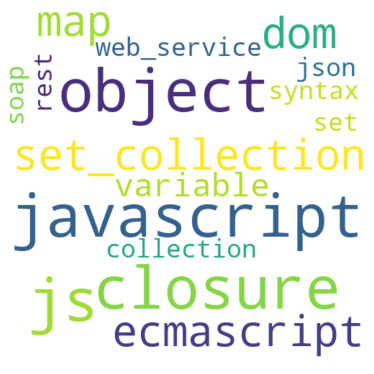

SESSION :  3
Challenges


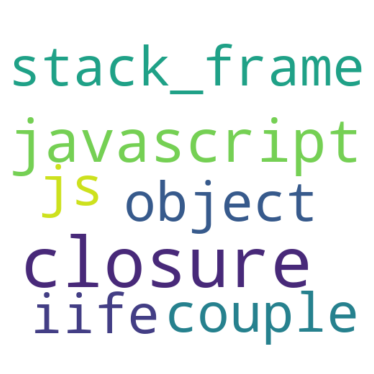

Outcome


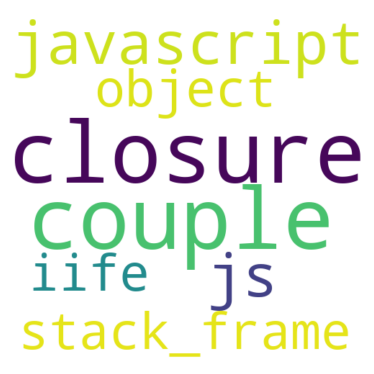

SESSION :  4
Challenges


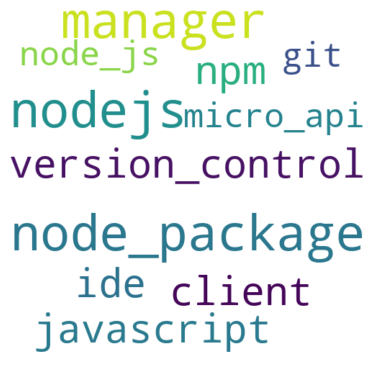

Outcome


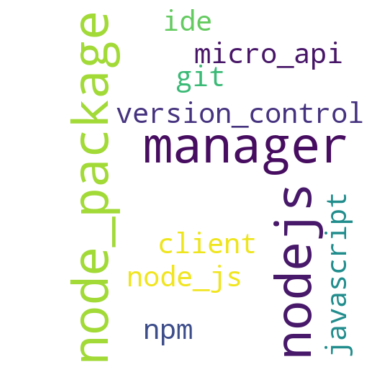

SESSION :  5
Challenges


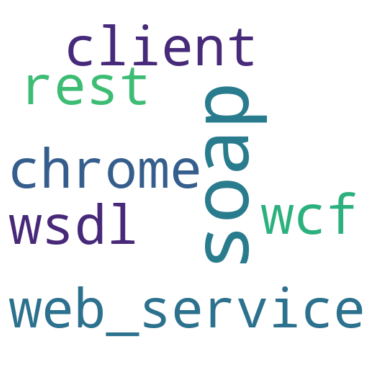

Outcome


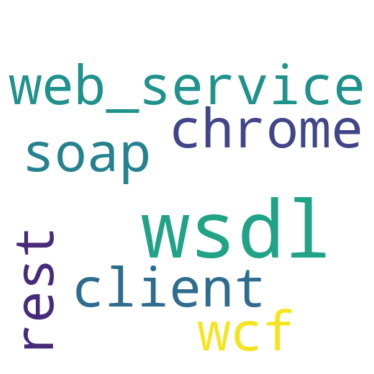

SESSION :  6
Challenges


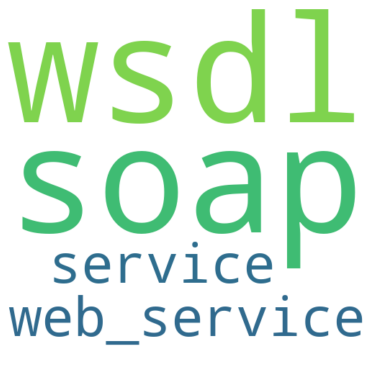

Outcome


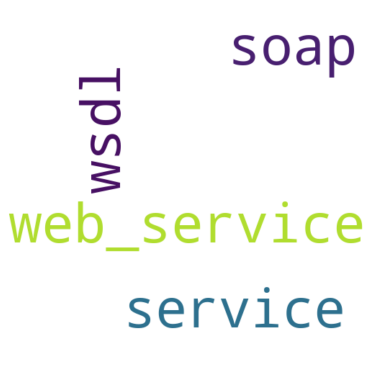

SESSION :  7
Challenges


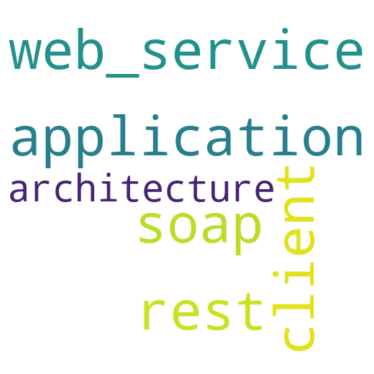

Outcome


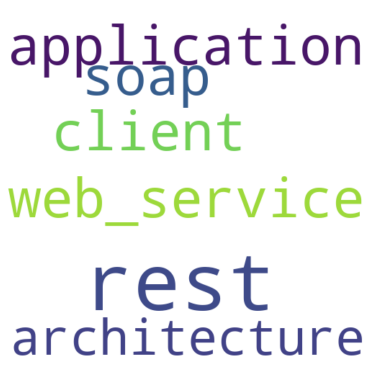

SESSION :  8
Challenges


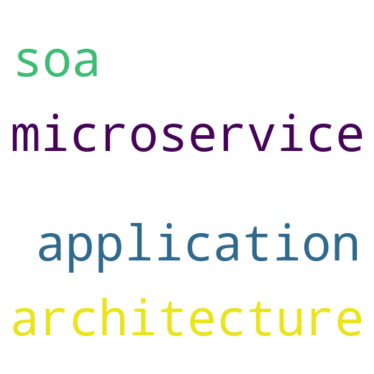

Outcome


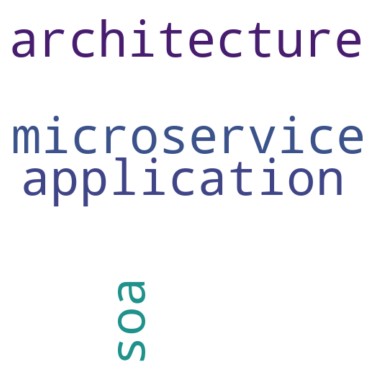

SESSION :  9
Challenges


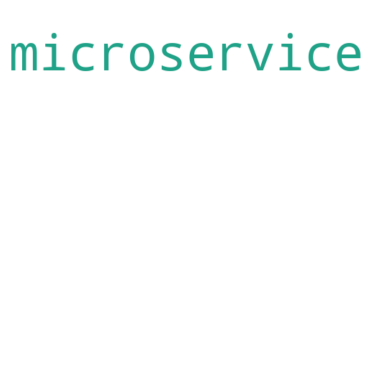

Outcome


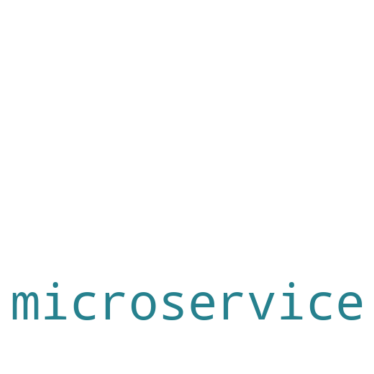

In [23]:
for sess in topic_wise:
    print("SESSION : ", sess)
    print("Challenges")
    create_WordCloud(topic_wise[sess]["challenge_topics"])
    print("Outcome")
    create_WordCloud(topic_wise[sess]["outcome_topics"])